In [1]:
%matplotlib inline
import tensorflow as tf  # TF2
import numpy as np
import cv2
from enum import Enum, auto, IntEnum
"""
# model data
intercept = 0.01259579
coef = np.array([ 0.01530813, -0.06361941,  0.01532825, -0.06312327,  0.03121793,
       -0.06225985,  0.00515395, -0.06413127,  0.04194056, -0.07163045,
        0.03679023, -0.05856963, -0.01321424, -0.05207514, -0.02547881,
        0.06326243,  0.05637735,  0.10507915, -0.1572394 ,  0.19343185,
        0.04664405,  0.21972535, -0.01213719, -0.00629819,  0.01213719,
        0.00629819, -0.19922164,  0.07706092,  0.19035918,  0.12944567,
       -0.25265423,  0.00517447,  0.22910392,  0.07066526])

"""


interpreter = tf.lite.Interpreter(
    model_path="legwork.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



In [2]:
test_sample = np.load("./data/legwork/legwork.MOV.npy")
test_sample = test_sample.reshape((-1,34))

In [5]:
estimated = []
for pose in test_sample:
    #result = np.exp(np.dot(pose, coef) + intercept)
    #result = result/(1+result)
    interpreter.set_tensor(input_details[0]['index'], pose.reshape(-1,34).astype(np.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]['index'])
    result = result[0,0]


    estimated.append(result)

In [4]:
state = 0
count = 0
upx = []
upy = []
downx = []
downy = []

filtered_estimated = []
for idx in range(6, len(estimated)-3):
    upCount = 0
    downCount = 0
    for j in range(idx-6, idx+1):
        if estimated[j] > 0.80:
            upCount+=1
        elif estimated[j] < 0.20:
            downCount+=1
    if upCount>4:
      filtered_estimated.append(1)
    elif downCount>4:
        filtered_estimated.append(0)
    else:
        filtered_estimated.append(estimated[idx])

estimated = filtered_estimated


last_up = 0
last_down = 0
mean_time_of_up_duration = -1
mean_time_of_down_duration = -1

for idx, esti in enumerate(estimated):
    if state==0: # 시작
        if esti > 0.80:
            ########
            last_up = idx
            ########
            upx.append(idx)
            upy.append(esti)
            #########
            state = 1
        elif esti < 0.20:
            state = 0
    elif state==1: # 서있는 상태
        if esti < 0.20:
            duration = idx - last_down
            if mean_time_of_down_duration == -1:
                mean_time_of_down_duration = duration
            else:
                if duration > mean_time_of_down_duration * 0.8:
                    mean_time_of_down_duration = (mean_time_of_down_duration + (idx - last_down))/2
                    last_down = idx
                    #########
                    downx.append(idx)
                    downy.append(esti)
                    #########
                    state = 2

        elif esti > 0.20:
            state = 1
    elif state==2: # 앉아있는 상태
        if esti > 0.80:
            duration = idx - last_up
            if mean_time_of_up_duration == -1:
                mean_time_of_up_duration = duration
            else:
                if duration > mean_time_of_up_duration * 0.8:
                    mean_time_of_up_duration = (mean_time_of_up_duration + (idx - last_up))/2
                    last_up = idx
                    #########
                    upx.append(idx)
                    upy.append(esti)
                    #########
                    state = 1
                    count += 1

        elif esti < 0.80:
            state = 2



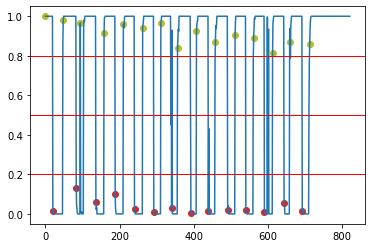

In [5]:
import matplotlib.pyplot as plt
plt.plot(estimated)
plt.axhline(y=0.5, color='r', linewidth=1)
plt.axhline(y=0.20, color='r', linewidth=1)
plt.axhline(y=0.80, color='r', linewidth=1)
plt.scatter(upx, upy,c='#bcbd22')
plt.scatter(downx, downy,c='#d62728')

plt.show()


estimated = np.array(estimated)